## **Практическое задание**

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import math
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
result_table = pd.DataFrame(columns=['OptimazerName', 'R2'])

**1. Создать Dataset для загрузки данных**

In [2]:
# класс для загрузки данных датасета sklearn.datasets.fetch_california_housing

class FetchCaliforniaHousingDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, standartization=True):
        self.X = data
        self.y = target
        self.standartization = standartization

        if self.standartization is True:
            self.X = StandardScaler().fit_transform(self.X)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        sample = self.X[index].astype(np.float32)   # изменить тип float64 на float32
        label = self.y[index].astype(np.float32).reshape(-1, 1)   # изменить тип float64 на float32 + изменим размерность [batch_size, 1]

        return sample, label

In [3]:
# загружаем датасет из sklearn
cal_housing = fetch_california_housing()

# разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data, cal_housing.target, test_size=0.25, random_state=13)

# создаем собственные датасеты
data_train = FetchCaliforniaHousingDataset(X_train, y_train)
data_test = FetchCaliforniaHousingDataset(X_test, y_test)

print(f'Train length: {len(data_train)}')
print(f'Test length: {len(data_test)}')

Train length: 15480
Test length: 5160


In [4]:
# посмотрим на единичные экземпляры
data_train[0], data_test[10]

((array([-0.18148348,  0.57913685, -0.34002075, -0.00446324, -0.06538332,
         -0.08711252, -0.67176217,  0.67560685], dtype=float32),
  array([[2.68]], dtype=float32)),
 (array([ 0.28412172,  0.8396363 , -0.2598781 , -0.1186917 , -0.97337216,
         -0.3103703 , -0.62853336,  0.6278174 ], dtype=float32),
  array([[1.958]], dtype=float32)))

**2. Обернуть в Dataloader**

In [5]:
BATCH_SIZE = 30

In [6]:
# сформируем батчи
data_train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=2, drop_last=True)

data_test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=2, drop_last=True)

print(f'Number of train batches: {len(data_train_loader)}')
print(f'Number of test batches: {len(data_test_loader)}')

Number of train batches: 516
Number of test batches: 172


In [7]:
# посмотрим на тензоры
for i, batch in enumerate(data_train_loader):
    print(i, batch)
    if i == 0:
      break

0 [tensor([[-2.9488e-01, -6.9374e-01, -1.9545e-01, -2.8379e-01, -9.7709e-01,
         -3.3919e-02,  1.5861e+00, -9.6527e-01],
        [-5.9263e-01,  2.2253e-02, -9.4705e-02, -2.1258e-01,  7.6897e-01,
          1.8519e-02,  1.3207e+00, -9.5035e-01],
        [-1.0959e+00,  2.2253e-02, -3.0103e-01, -3.5703e-01, -1.3404e-01,
          1.6287e-02,  3.6173e-01, -5.0357e-02],
        [-8.7763e-01,  3.4047e-01, -8.4127e-01, -1.5592e-01,  9.8364e-01,
          1.5642e-01, -7.6021e-01,  6.6566e-01],
        [-3.6388e-01,  9.7691e-01,  2.5927e-01, -1.4305e-01, -4.5301e-01,
         -4.1563e-02,  2.3868e+00, -2.2680e+00],
        [-1.0643e+00, -5.7302e-02, -1.4860e-01,  1.3693e-01, -5.2167e-01,
         -1.6587e-02,  1.6047e+00, -9.8516e-01],
        [-6.0025e-02, -8.5285e-01,  3.0517e-01,  1.8475e-01,  1.0836e+00,
         -3.5821e-02, -6.9969e-01,  1.7837e-01],
        [ 1.4102e+00, -6.9374e-01,  3.0859e-01, -2.2362e-01, -5.4861e-01,
         -2.3999e-02, -9.8367e-01,  9.4411e-01],
        [ 2.0

**3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)**

In [8]:
# создадим архитектуру сети

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 3*hidden_dim)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(0.1)
        self.bn = nn.BatchNorm1d(3*hidden_dim)
        self.fc2 = nn.Linear(3*hidden_dim, output_dim)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x


    def predict(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [9]:
INPUT_DIMENSION = len(data_train[0][0])
HIDDEN_DIMENSION = 100
OUTPUT_DIMENSION = 1

In [10]:
# print(torch.seed())
torch.manual_seed(11340019636634753458)
net = Net(INPUT_DIMENSION, HIDDEN_DIMENSION, OUTPUT_DIMENSION)
print(net)

Net(
  (fc1): Linear(in_features=8, out_features=300, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.1, inplace=False)
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)


In [11]:
net.fc1.weight[0][:5]

tensor([-0.2354,  0.0023, -0.0441, -0.0024, -0.0438], grad_fn=<SliceBackward0>)

In [12]:
torch.initial_seed()

11340019636634753458

In [13]:
# зададим оптимизатор и критерий
# optimizer = torch.optim.SGD(net.parameters(), lr=5e-3)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [14]:
# обучим модель

num_epochs = 3

for epoch in range(num_epochs):  
    running_loss, running_items = 0.0, 0.0
    for i, data in enumerate(data_train_loader):
        inputs, labels = data[0], data[1]
        labels = labels.reshape(-1, 1)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)

        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            true_labels = np.array([labels[j][0] for j in range(len(labels))])
            pred_labels = np.array([outputs.detach().numpy()[j][0] for j in range(len(outputs))])

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(data_train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'R2: {r2_score(true_labels, pred_labels):.3f}', end='. ')

            test_running_total = 0.0
            for i, data in enumerate(data_test_loader):            
                 test_outputs = net(data[0])
                 test_labels = data[1].reshape(-1, 1)
                 test_running_total += len(data[1])
                 
                 test_true_labels = np.array([test_labels[j][0] for j in range(len(test_labels))])
                 test_pred_labels = np.array([test_outputs.detach().numpy()[j][0] for j in range(len(test_outputs))])
            
            
            print(f'Test R2: {r2_score(test_true_labels, test_pred_labels):.3f}')
            net.train()
  
        
print('Training is finished!')

Epoch [1/3]. Step [1/516]. Loss: 0.200. R2: -3.634. Test R2: -3.917
Epoch [1/3]. Step [301/516]. Loss: 0.132. R2: -2.817. Test R2: -1.037
Epoch [2/3]. Step [1/516]. Loss: 0.036. R2: -0.856. Test R2: -0.245
Epoch [2/3]. Step [301/516]. Loss: 0.048. R2: 0.209. Test R2: 0.030
Epoch [3/3]. Step [1/516]. Loss: 0.028. R2: 0.389. Test R2: 0.350
Epoch [3/3]. Step [301/516]. Loss: 0.023. R2: 0.153. Test R2: 0.719
Training is finished!


In [15]:
# посмотрим результаты на тесте
net.eval()
data_iter = iter(data_test_loader)
test_samples, test_labels = data_iter.next()

In [16]:
# делаем предсказания
predictions = net.predict(test_samples)
# predictions

In [47]:
# формируем списки исходных и предсказанных значений
test_true_labels = np.array([test_labels[j][0][0] for j in range(len(test_labels))])
predictions_labels = np.array([predictions.detach().numpy()[j][0] for j in range(len(test_labels))])

print(test_true_labels[:5])
print(predictions_labels[:5])

[2.583 1.158 1.418 4.5   1.403]
[ 2.5155165   2.08492     1.4995068   3.7987003  -0.04628997]


In [18]:
# смотрим метрику 
R2 = r2_score(test_true_labels, predictions_labels)
print(R2)

0.7209921358083264


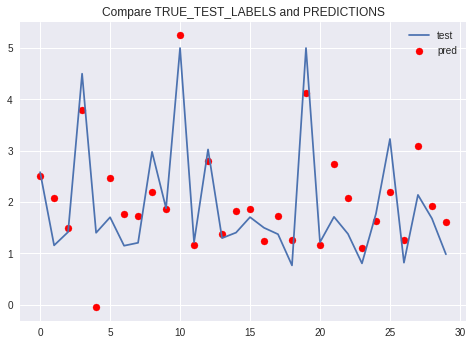

In [48]:
# посмотрим на график
plt.plot(range(len(test_true_labels)), test_true_labels, label='test')
plt.scatter(range(len(predictions_labels)), predictions_labels, c='red', label='pred')
plt.title('Compare TRUE_TEST_LABELS and PREDICTIONS')
plt.legend(loc='best')
plt.show()

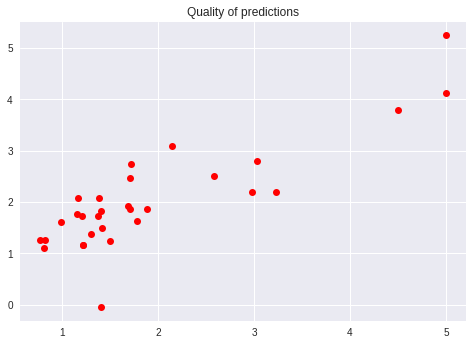

In [51]:
# стандартный способ демонстрации качества предсказания регрессии
plt.plot(test_true_labels, predictions_labels, 'ro')
plt.title('Quality of predictions')
plt.show()

**4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели**

In [20]:
# R2_SGD = np.copy(R2)
# result_table.loc[0] = ['SGD', R2_SGD]

# R2_Adam = np.copy(R2)
# result_table.loc[1] = ['Adam', R2_Adam]

R2_RMSProp = np.copy(R2)
result_table.loc[2] = ['RMSProp', R2_RMSProp]

result_table

,OptimazerName,R2
2,RMSProp,0.7209921358083264


### **Вывод:**

При прочих равных параметрах модели наилучшим образом сошелся оптимизатор **SGD** (lr=5e-3). При этом значение шага понадобилось сделать меньше, чем у оптимизаторов **Adam** и **RMSprop** (lr=1e-4).
В целом модель находит общие закономерности, но достичь идеально точных значений довольно сложно.